In [9]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\qchen\Documents\qchen.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [252]:
date_key = 20170912

travel_times_sql = '''
-- takes the arrivaltime_fromstop for each trip_id and identifies the bin(s) it falls into
--drop table trip_bin15;
create temp table trip_bin15 as(
select bt_id, bt_id_name, trip_id, 
(timestamp without time zone 'epoch' + (floor((extract('epoch' from arrivaltime_fromstop) / 900 )) * 900) * INTERVAL '1 second') bin15
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id, bin15
order by bt_id, bt_id_name, bin15
);

-- gives the sum of a trip_id's travel times for the bluetooth segment
--drop table tt_sum;
create temp table tt_sum as(
select bt_id, bt_id_name, trip_id, sum(extract(epoch from (arrivaltime_tostop - arrivaltime_fromstop))) travel_time
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id
order by bt_id, bt_id_name, trip_id
);

-- grabs earliest bin for each trip_id to associate the travel times to
--drop table tween;
create temp table tween as(
select t.bt_id, t.bt_id_name, t.trip_id, travel_time, min(bin15) timebin
from tt_sum t
inner join trip_bin15 b using (trip_id)
where travel_time > 0
group by t.bt_id, t.bt_id_name, t.trip_id, travel_time
order by t.bt_id, t.bt_id_name, timebin, t.trip_id
);

-- averages the travel times that fall within the same bin
select bt_id, bt_id_name, round(avg(travel_time)::numeric, 0)::integer avg_tt, timebin
from tween
where travel_time > 0
group by bt_id, bt_id_name, timebin
order by bt_id, bt_id_name, timebin
'''

travel_times = pandasql.read_sql(travel_times_sql.format(date_key), con)


trip_sql = '''
-- takes the arrivaltime_fromstop for each trip_id and identifies the bin(s) it falls into
--drop table trip_bin;
create temp table trip_bin as(
select bt_id, bt_id_name, trip_id, 
(timestamp without time zone 'epoch' + (floor((extract('epoch' from arrivaltime_fromstop) / 900 )) * 900) * INTERVAL '1 second') bin15
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id, bin15
order by bt_id, bt_id_name, bin15
);

-- gives the sum of a trip_id's travel times for the bluetooth segment
--drop table tt_su;
create temp table tt_su as(
select bt_id, bt_id_name, trip_id, sum(extract(epoch from (arrivaltime_tostop - arrivaltime_fromstop))) travel_time
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id
order by bt_id, bt_id_name, trip_id
);

-- grabs earliest bin for each trip_id to associate the travel times to
select t.bt_id, t.trip_id, travel_time::integer, min(bin15) timebin
from tt_su t
inner join trip_bin b using (trip_id)
where travel_time > 0
group by t.bt_id, t.bt_id_name, t.trip_id, travel_time
order by t.bt_id, t.bt_id_name, timebin, t.trip_id
'''

trip_tt = pandasql.read_sql(trip_sql.format(date_key), con)


#stt_sql = '''--drop table stt_sum;
#create temp table stt_sum as(
#select bt_id, bt_id_name, trip_id, sum(extract(epoch from (scheduledarrivaltime_tostop - scheduledarrivaltime_fromstop))) travel_time, 
#(timestamp without time zone 'epoch' + (floor((extract('epoch' from scheduledarrivaltime_fromstop) / 900 )) * 900) * INTERVAL '1 second') timebin
#from ttc.avl a
#inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
#where date_key = {0}
#group by trip_id, bt_id, bt_id_name, timebin
#order by bt_id, bt_id_name, timebin
#);
#
#select bt_id, bt_id_name, round(avg(travel_time)::numeric, 0)::integer avg_tt, timebin
#from stt_sum
#where travel_time > 0
#group by bt_id, bt_id_name, timebin
#order by bt_id, bt_id_name, timebin'''
#
#scheduled_travel_times = pandasql.read_sql(stt_sql.format(date_key), con)

In [253]:
travel_times

,bt_id,bt_id_name,avg_tt,timebin
0,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,263,2017-09-12 00:00:00
1,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,230,2017-09-12 00:15:00
2,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,240,2017-09-12 00:30:00
3,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,267,2017-09-12 00:45:00
4,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,270,2017-09-12 01:00:00
5,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,200,2017-09-12 01:15:00
6,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,300,2017-09-12 05:00:00
7,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,260,2017-09-12 05:15:00
8,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,200,2017-09-12 05:30:00
9,19,DT-0019. Queen-EB_Roncesvalles-to-Dufferin,340,2017-09-12 05:45:00


In [254]:
trip_tt

,bt_id,trip_id,travel_time,timebin
0,19,35157588,280,2017-09-12 00:00:00
1,19,35157589,240,2017-09-12 00:00:00
2,19,35157590,260,2017-09-12 00:00:00
3,19,35157632,340,2017-09-12 00:00:00
4,19,35157633,260,2017-09-12 00:00:00
5,19,35157634,200,2017-09-12 00:00:00
6,19,35157636,260,2017-09-12 00:00:00
7,19,35157591,260,2017-09-12 00:15:00
8,19,35157637,200,2017-09-12 00:15:00
9,19,35157592,220,2017-09-12 00:30:00


In [224]:
def plot_tt(table):
    bt_list = table.bt_id.unique()
    fig, ax = plt.subplots(len(bt_list), 1, sharex = False, sharey = True, figsize = (16, 4*len(bt_list)))
    print('Travel times by Bluetooth segment for ' + str(date_key))
    
    for i, segment in enumerate(bt_list):
        tempdf = table[table['bt_id'] == segment]
        ax[i].plot_date(y = tempdf['avg_tt'],
                     x = tempdf['timebin'],
                     xdate = True,
                     fmt = '-o')
        ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 1))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax[i].set_title(tempdf['bt_id_name'].unique()[0])
        for label in ax[i].get_xmajorticklabels():
            label.set_rotation(30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

In [258]:
bt_list = travel_times.bt_id.unique()
for i, segment in enumerate(bt_list):
    print(segment)
    indiv = trip_tt[trip_tt['bt_id'] == segment]


,bt_id,trip_id,travel_time,timebin
6192,66,35159145,280,2017-09-12 00:00:00
6193,66,35159148,340,2017-09-12 00:00:00
6194,66,35159149,300,2017-09-12 00:00:00
6195,66,35159152,360,2017-09-12 00:15:00
6196,66,35159153,300,2017-09-12 00:15:00
6197,66,35159154,280,2017-09-12 00:30:00
6198,66,35159156,260,2017-09-12 00:45:00
6199,66,35159157,260,2017-09-12 01:00:00
6200,66,35159162,300,2017-09-12 01:15:00
6201,66,35159132,300,2017-09-12 01:30:00


In [259]:
indiv.bt_id.unique()

array([66], dtype=int64)

In [260]:
bt_list

array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66], dtype=int64)

In [285]:
def plot_ttavg(avgtable, indtable):
    bt_list = [27, 28, 57, 58] #avgtable.bt_id.unique()
    fig, ax = plt.subplots(len(bt_list), 1, sharex = False, sharey = True, figsize = (16, 3.5*len(bt_list)))
    print('Travel times by Bluetooth segment for ' + str(date_key))
    
    bx = []
    for i, segment in enumerate(bt_list):
        indiv = indtable[indtable['bt_id'] == segment]
        avgdf = avgtable[avgtable['bt_id'] == segment]
        bx.append(ax[i].twiny())
        ax[i].plot_date(y = indiv['travel_time'], 
                        x = indiv['timebin'], 
                        xdate = True,
                        fmt = 'o', 
                        color = 'b')
        
        bx[i].plot_date(y = avgdf['avg_tt'],
                        x = avgdf['timebin'],
                        xdate = True,
                        fmt = '-', 
                        color = 'r')
        
        ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 1))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax[i].set_title(avgdf['bt_id_name'].unique()[0])
        bx[i].get_xaxis().set_visible(False)
        for label in ax[i].get_xmajorticklabels():
            label.set_rotation(30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

With Trips
Travel times by Bluetooth segment for 20170912


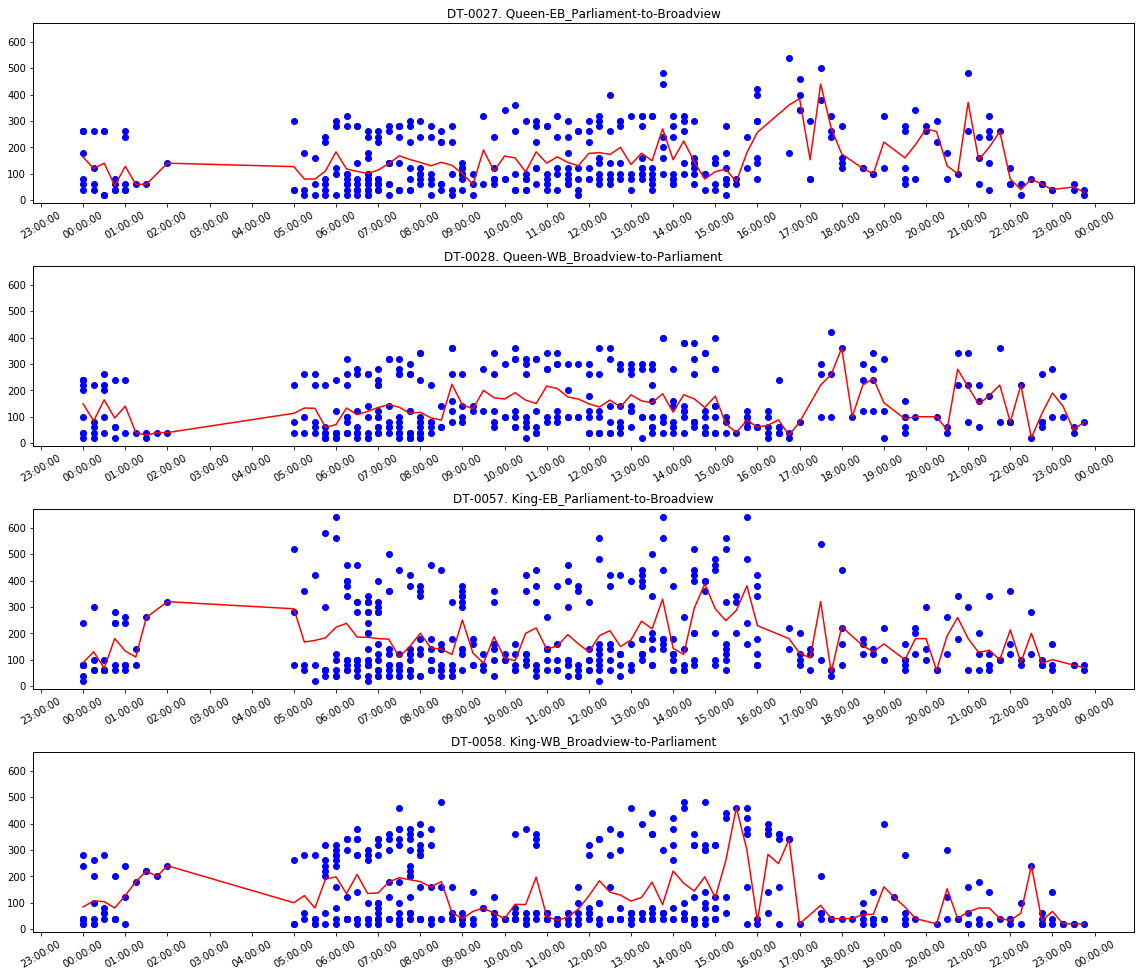

In [286]:
print('With Trips')
plot_ttavg(travel_times, trip_tt)

Actual
Travel times by Bluetooth segment for 20170912


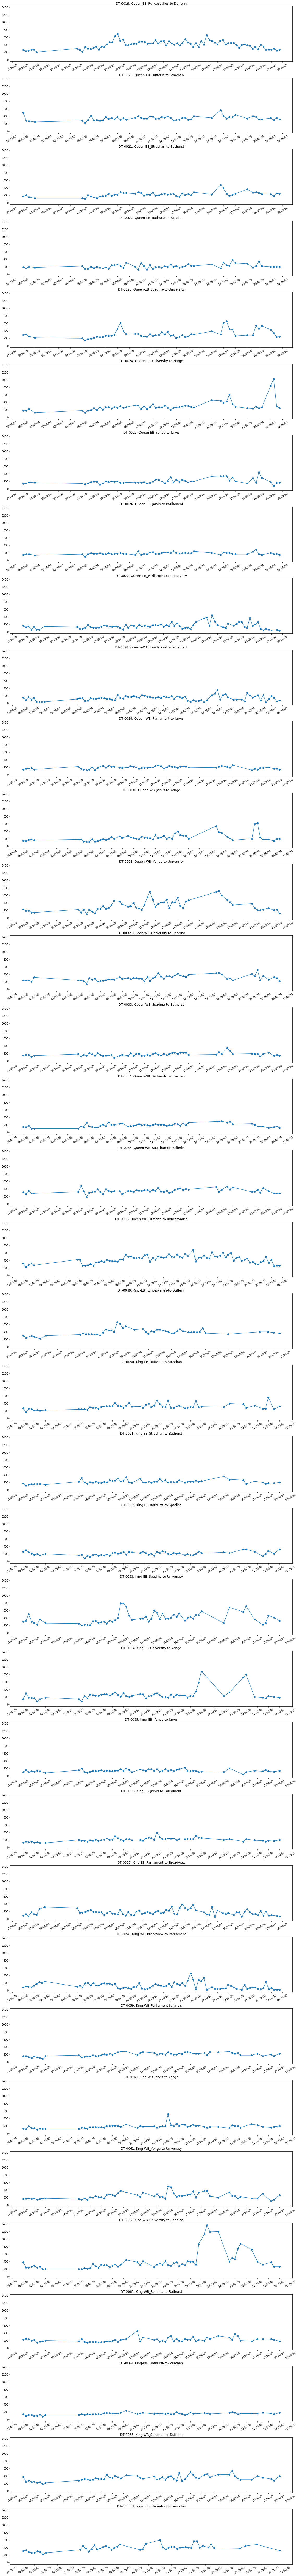

In [225]:
print('Actual')
plot_tt(travel_times)

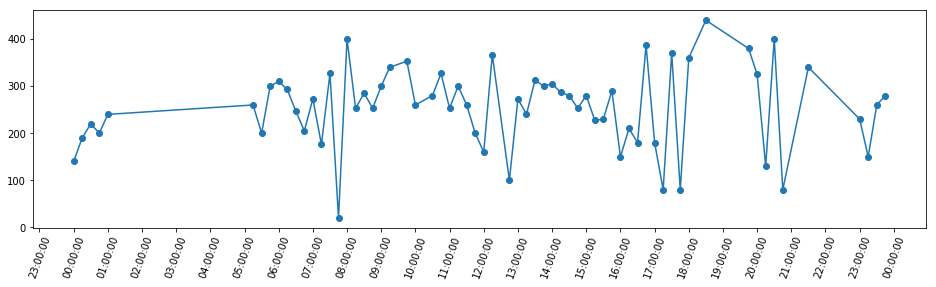

In [87]:
fig, ax = plt.subplots(figsize = (16, 4))
ax.plot_date(y = travel_times['avg_tt'],
             x = travel_times['timebin'],
             xdate = True,
             fmt = '-o')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=70)
plt.show()